# WhoAreYou?

## Import requirements

In [49]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np 

In [64]:
image1 = cv2.imread('./images/rouhani.jpeg')
image2 = cv2.imread('./images/raisi.jpeg')

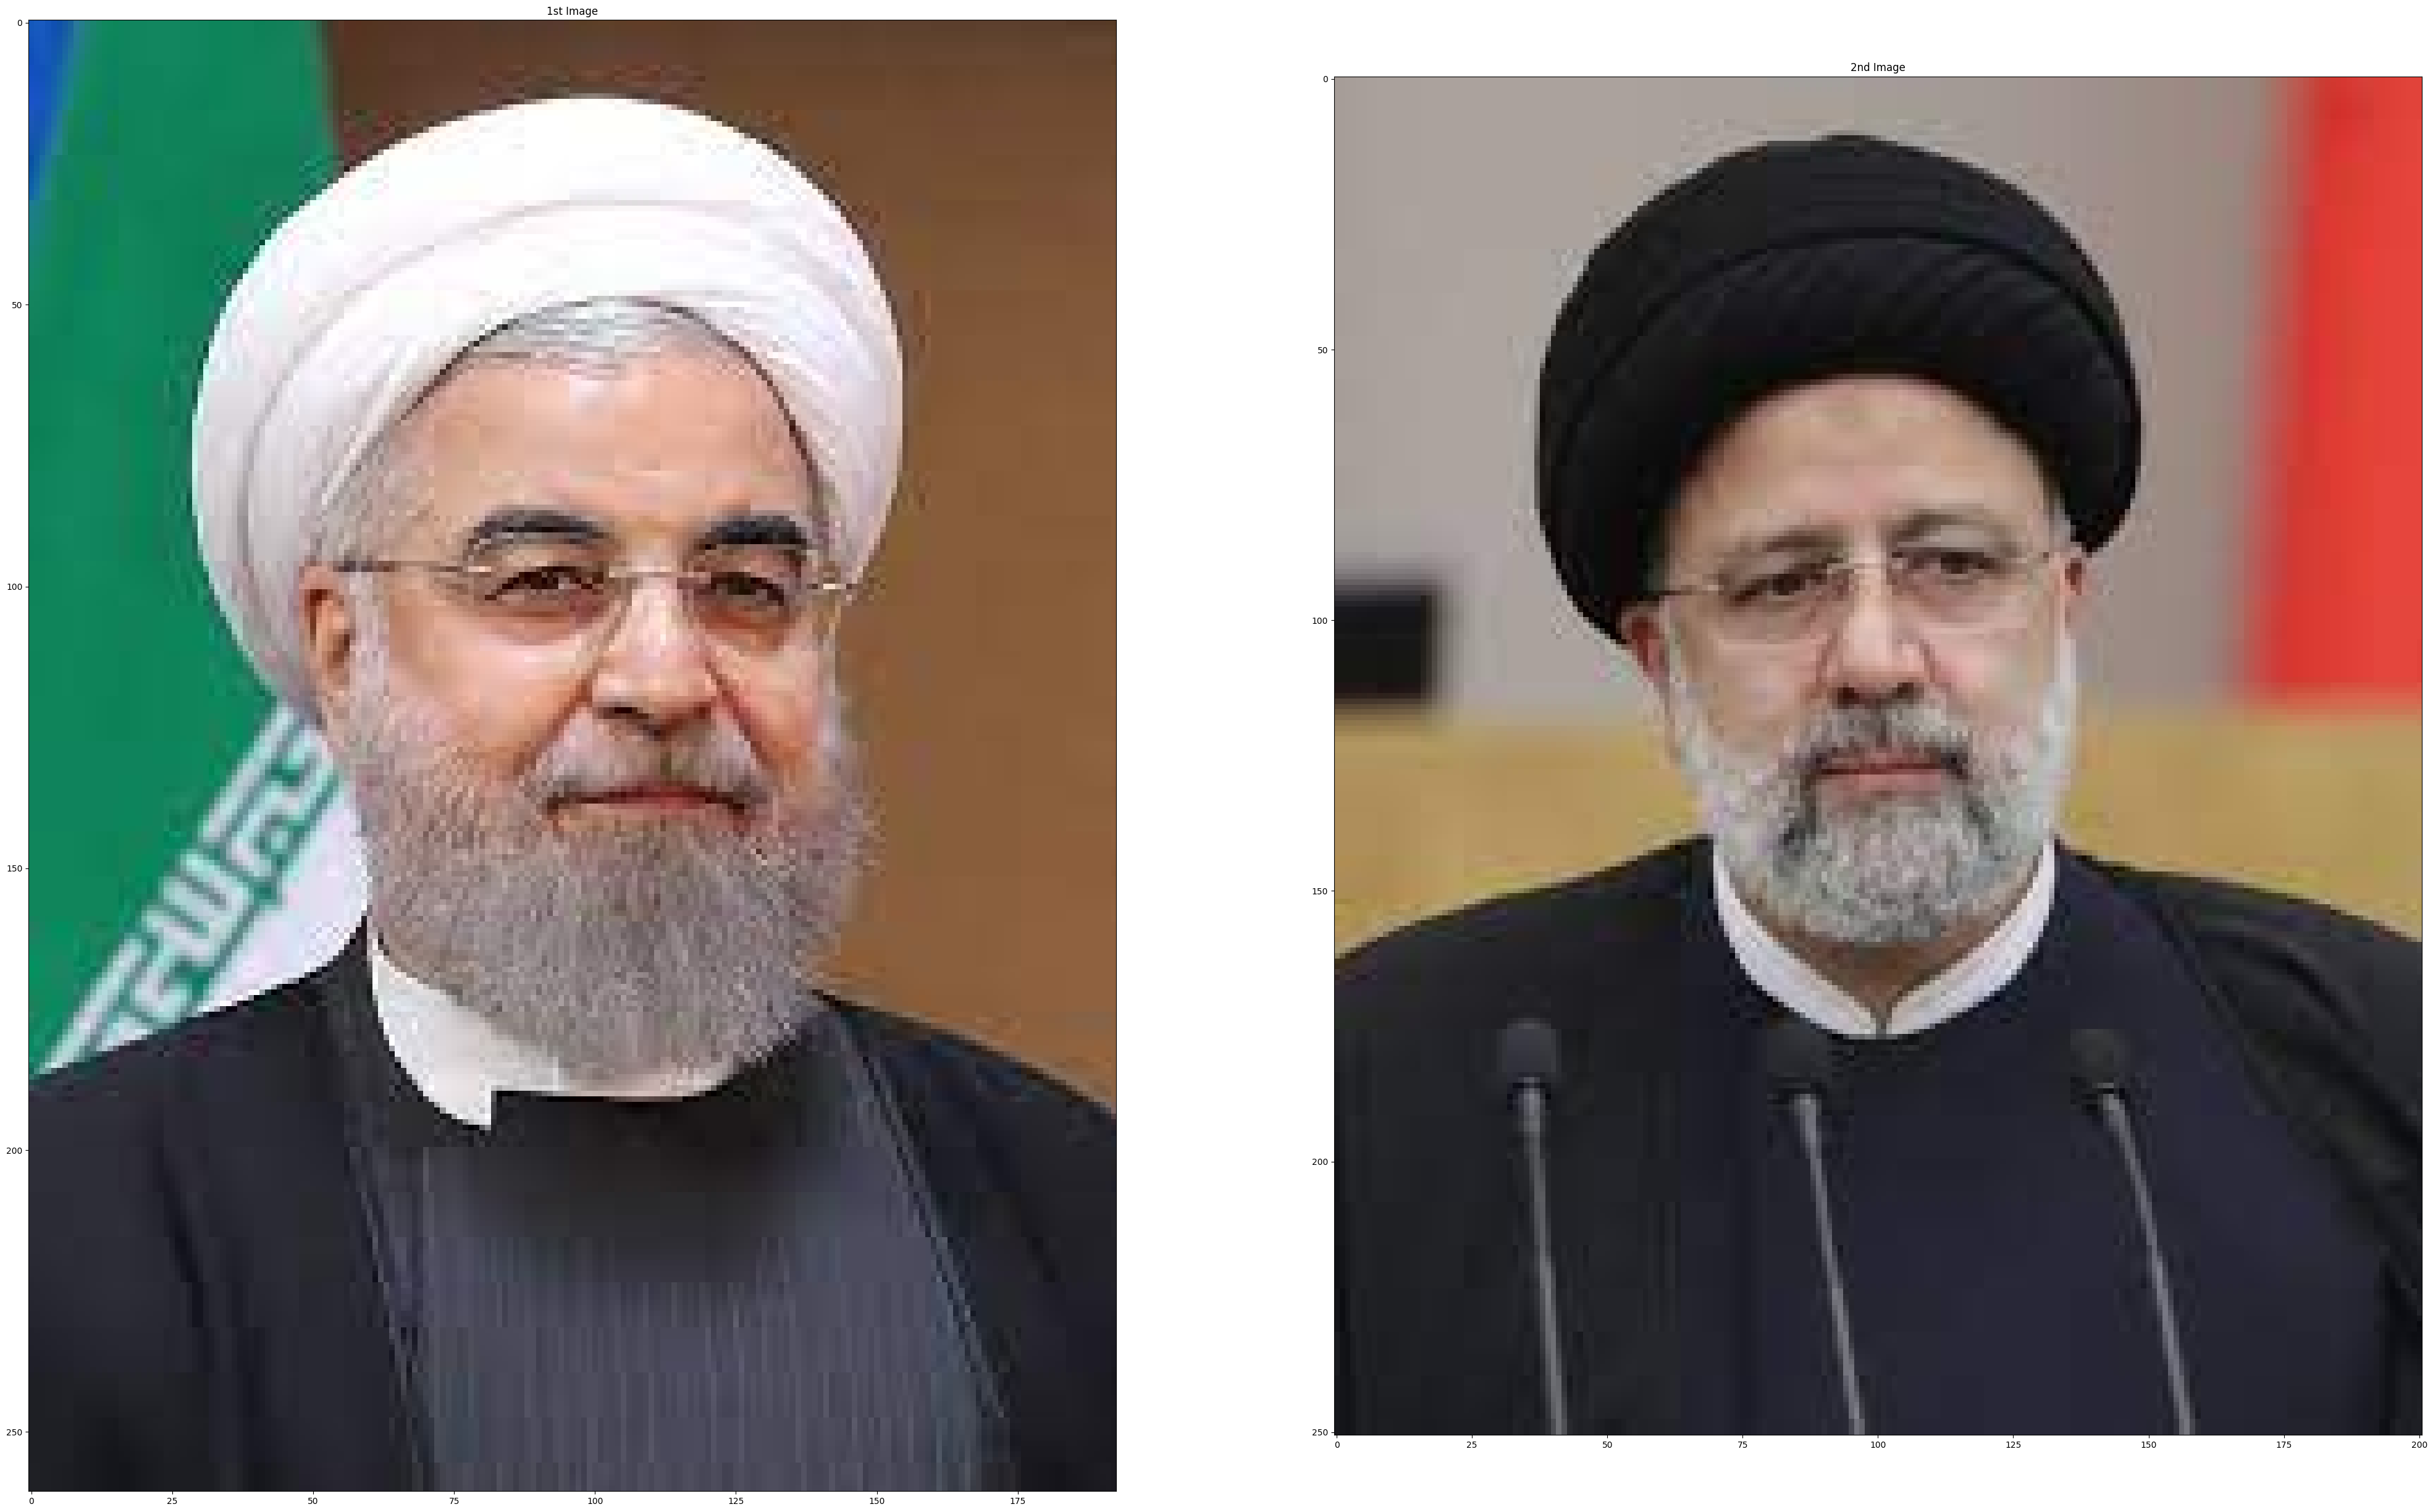

In [65]:
plt.figure(figsize=(50, 100))

plt.subplot(121); plt.imshow(image1[...,::-1]);plt.title('1st Image');
plt.subplot(122); plt.imshow(image2[...,::-1]);plt.title('2nd Image');

## Facial Landmark Detection
The geometry of the two faces is very different, so we need to warp the source face a bit so that it covers the target face, we also want to make sure we don't wrap it beyond recognition. We first detect facial landmarks on both images using the [mediapipe](https://google.github.io/mediapipe/solutions/face_mesh#refine_landmarks). 

In [66]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

For statice images:

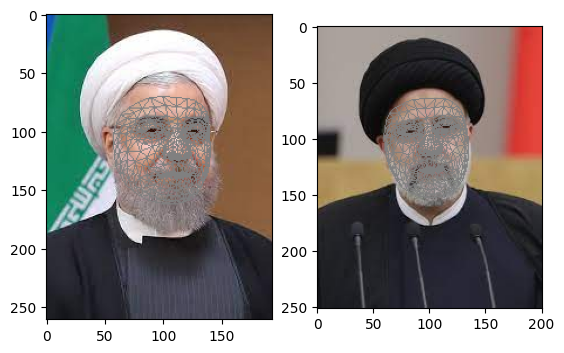

In [67]:
landmarks = []
with mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=2,
        refine_landmarks=True,
        min_detection_confidence=0.5
    ) as face_mesh:
    for index, image in enumerate([image1, image2]):
        height, weight, _ = image.shape
        landmarks.append([])
        
        # Convert the BGR image to RGB.
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        results = face_mesh.process(rgb_image)
        
        if not results.multi_face_landmarks:
            print("No face landmark detected in the image...")
            continue
        annotated_image = image.copy()
        
        for face_landmarks in results.multi_face_landmarks:
            # draw the landmarks
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_TESSELATION,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing_styles
              .get_default_face_mesh_tesselation_style())
            
            # Save the x, y of landmarks
            for lm in face_landmarks.landmark:
                x,y = int(lm.x * weight), int(lm.y * height)
                landmarks[index].append([x, y])
            plt.subplot(1,2,index+1); plt.imshow(annotated_image[...,::-1]);

we do not and should not use all the points for face alignment. We need the points on the outer boundary of the face.

## Find Convex Hull
A boundary that does not have any concavities is called a “Convex Hull”. The previous image shows facial landmarks detected using Mediapipe in gray and below the convex hull of the points is shown in blue. The convex hull of a set of points can be calculated using OpenCV’s convexHull function.

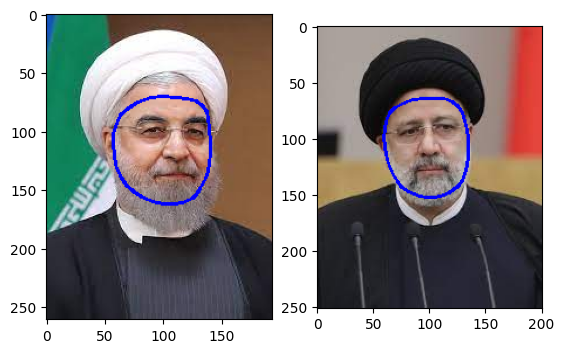

In [72]:
landmarks = np.array(landmarks)
hullIndexs = [cv2.convexHull(lm) for lm in landmarks]

copy_images = [image1.copy(), image2.copy()]

plt.figure()
for i, image in enumerate(copy_images):
    cv2.drawContours(image, [hullIndexs[i]], -1, (255, 0, 0), 2)
    plt.subplot(1,2, i+1); plt.imshow(image[...,::-1])